# Home Credit - Problematic Client Analysis

Nama : Alfito Putra Fajar Pratama

email: alfito.pfp@gmail.com

**Outline**
- Data Load and Identification
- Preprocessing
- EDA
- Modeling
- Conclusion

## Package Python

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2
from scipy.stats import chi2 as chi2_distribution

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
import joblib

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

import statsmodels.formula.api as smf
import statsmodels.api as sm

## Data Load and Problem Research

In [3]:
columns_desc = pd.read_csv('home-credit-default-risk/HomeCredit_columns_description.csv', encoding='ISO-8859-1')
columns_desc.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [4]:
pd.options.display.max_colwidth = None
target_column = columns_desc[columns_desc['Row'] == 'WEEKDAY_APPR_PROCESS_START']
print(target_column[['Description', 'Table']])

                                                                Description  \
32               On which day of the week did the client apply for the loan   
181  On which day of the week did the client apply for previous application   

                            Table  
32   application_{train|test}.csv  
181      previous_application.csv  


**Definisi Target**
1. Klien dengan kesulitan pembayaran:
   - Memiliki keterlambatan lebih dari X hari pada setidaknya satu dari Y cicilan pertama.
0. Semua kasus lainnya (tidak mengalami keterlambatan melebihi X hari atau tidak pada Y cicilan pertama).

Kesimpulan:

Ini adalah masalah klasifikasi biner.
Informasi dari data historis pembayaran, baik cicilan saat ini maupun sebelumnya, sangat relevan untuk prediksi.

In [5]:
app_train = pd.read_csv('home-credit-default-risk/application_train.csv')
app_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Tabel utama dengan data statis untuk setiap pinjaman.

In [6]:
bureau = pd.read_csv('home-credit-default-risk/bureau.csv')
bureau.head(5)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [7]:
bureau_balance = pd.read_csv('home-credit-default-risk/bureau_balance.csv')

bureau_balance.head(5)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


`bureau.csv` and `bureau_balance.csv`: Menyediakan data biro kredit, memberikan wawasan tentang pinjaman masa lalu klien dari institusi lain.

In [8]:
pos_cash_balance = pd.read_csv('home-credit-default-risk/POS_CASH_balance.csv')
pos_cash_balance.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


`POS_CASH_balance.csv`: Saldo bulanan untuk POS dan pinjaman tunai sebelumnya.

In [9]:
credit_card_balance = pd.read_csv('home-credit-default-risk/credit_card_balance.csv')
credit_card_balance.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


`credit_card_balance.csv`: Saldo bulanan untuk pinjaman kartu kredit sebelumnya.

In [10]:
installments_payments = pd.read_csv('home-credit-default-risk/installments_payments.csv')
installments_payments.head(5)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


installments_payments.csv: Riwayat pembayaran untuk pinjaman sebelumnya.

In [11]:
previous_application = pd.read_csv('home-credit-default-risk/previous_application.csv')
previous_application.head(5)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


`previous_application.csv`: Riwayat aplikasi Home Credit klien.

In [12]:
column_types = app_train.dtypes.value_counts()
print("Jumlah kolom berdasarkan tipe data dalam application data:")
print(column_types)

Jumlah kolom berdasarkan tipe data dalam application data:
float64    65
int64      41
object     16
dtype: int64


## Preprocessing

### Data Cleaning

#### Missing Values

In [13]:
pd.options.display.max_rows = None

missing_values = app_train.isnull().sum()
missing_values_percent = (missing_values / len(app_train)) * 100

missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_values_percent
}).sort_values(by='Missing Values', ascending=False)
missing_data = missing_data[missing_data['Missing Values']>= 0.1]

print("Missing value dan proporsinya:")
missing_data

Missing value dan proporsinya:


,Missing Values,Percentage (%)
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


In [14]:
columns_to_drop = missing_data[missing_data['Percentage (%)'] > 19].index.tolist()
app_train_cleaned = app_train.drop(columns=columns_to_drop, axis=1)

print(f"Kolom yang dihapus: {len(columns_to_drop)}")

Kolom yang dihapus: 51


Kolom yang memiliki proporsi diatas 20% akan dihapus dikarenakan karena kontribusinya cenderung rendah

In [15]:
columns_to_drop = [
    'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR'
]

app_train_cleaned = app_train_cleaned.drop(columns=columns_to_drop, axis=1)

columns_to_impute_median = [
    'EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'DAYS_LAST_PHONE_CHANGE',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_ANNUITY'
]

columns_to_impute_mode = [
    'CNT_FAM_MEMBERS', 'NAME_TYPE_SUITE'
]

for col in columns_to_impute_median:
    app_train_cleaned[col] = app_train_cleaned[col].fillna(app_train_cleaned[col].median())

for col in columns_to_impute_mode:
    app_train_cleaned[col] = app_train_cleaned[col].fillna(app_train_cleaned[col].mode()[0])

print("Sisa missing value setelah imputasi dan penghapusan:")
print(app_train_cleaned.isnull().sum().sum())


Sisa missing value setelah imputasi dan penghapusan:
0


Sisa kolom yang masih terdapat missing value diatasi dengan dua hal:
1.  penghapusan kolom AMT_REQ_CREDIT_BUREAU_*
    - Kolom ini berisi jumlah permintaan informasi ke Credit Bureau dalam berbagai rentang waktu (jam, hari, minggu, bulan, kuartal, tahun). Meskipun informasi ini mungkin memberikan wawasan tentang frekuensi pengecekan kredit, relevansi langsung terhadap target variabel (TARGET: default payment) biasanya rendah, terutama dibandingkan dengan variabel lain seperti skor eksternal (EXT_SOURCE_*) atau detail kredit sebelumnya.
2.  Variabel kontinu diamputasi dengan nilai median, karena median tidak dipengaruhi oleh nilai ekstrem (outlier) dalam data, sehingga lebih stabil dibandingkan rata-rata (mean). Variabel kategori diamputasi dengan nilai modus

In [16]:
app_train_cleaned.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0


#### Categorical Encoding

In [17]:
app_train_cleaned.select_dtypes(include=['object', 'category']).columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE'],
      dtype='object')

In [18]:
le = LabelEncoder()
string_columns = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE']

label_mappings = {}

for column in string_columns:
    app_train_cleaned[column] = le.fit_transform(app_train_cleaned[column])
    label_mappings[column] = dict(enumerate(le.classes_))

app_train_cleaned.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0


In [19]:
for column, mapping in label_mappings.items():
    print(f"\nMapping untuk kolom '{column}':")
    for key, value in mapping.items():
        print(f"  {key} -> {value}")


Mapping untuk kolom 'NAME_CONTRACT_TYPE':
  0 -> Cash loans
  1 -> Revolving loans

Mapping untuk kolom 'CODE_GENDER':
  0 -> F
  1 -> M
  2 -> XNA

Mapping untuk kolom 'FLAG_OWN_CAR':
  0 -> N
  1 -> Y

Mapping untuk kolom 'FLAG_OWN_REALTY':
  0 -> N
  1 -> Y

Mapping untuk kolom 'NAME_TYPE_SUITE':
  0 -> Children
  1 -> Family
  2 -> Group of people
  3 -> Other_A
  4 -> Other_B
  5 -> Spouse, partner
  6 -> Unaccompanied

Mapping untuk kolom 'NAME_INCOME_TYPE':
  0 -> Businessman
  1 -> Commercial associate
  2 -> Maternity leave
  3 -> Pensioner
  4 -> State servant
  5 -> Student
  6 -> Unemployed
  7 -> Working

Mapping untuk kolom 'NAME_EDUCATION_TYPE':
  0 -> Academic degree
  1 -> Higher education
  2 -> Incomplete higher
  3 -> Lower secondary
  4 -> Secondary / secondary special

Mapping untuk kolom 'NAME_FAMILY_STATUS':
  0 -> Civil marriage
  1 -> Married
  2 -> Separated
  3 -> Single / not married
  4 -> Unknown
  5 -> Widow

Mapping untuk kolom 'NAME_HOUSING_TYPE':
  0

### Feature Engineering

**Data bureau**

Feature engineering yang dilakukan terhadap data bureau bertujuan untuk membuat agregasi dan metrik baru yang dapat memberikan informasi yang lebih ringkas dan relevan mengenai hubungan kredit sebelumnya dengan klien saat ini.

Fitur yang didapatkan adalah:

- TOTAL_CREDITS: 
  - Riwayat kredit klien. 
  - Semakin banyak kredit sebelumnya, semakin besar kemungkinan mereka memiliki pengalaman dalam mengelola kredit.

- ACTIVE_CREDITS:  
  - Memberikan gambaran tentang kewajiban kredit klien saat ini. 
  - Banyak kredit aktif dapat mengindikasikan beban hutang yang lebih besar.

- AVG_DAYS_CREDIT: 
  - Frekuensi klien mengajukan kredit. 
  - Memberikan wawasan tentang jarak waktu antar kredit sebelumnya. Klien yang sering mengajukan kredit 
(rata-rata hari kecil) mungkin berisiko lebih tinggi.

- CLOSED_CREDITS: 
  - Menghitung jumlah kredit yang sudah selesai. 
  - Kredit yang sudah selesai menunjukkan riwayat pengelolaan kredit yang berhasil. Banyak kredit selesai dapat menunjukkan kemampuan klien dalam melunasi hutang.

- ACTIVE_CREDIT_RATIO: 
  - Membandingkan jumlah kredit aktif terhadap total kredit untuk setiap klien.

In [20]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [21]:
total_credits_per_client = bureau.groupby('SK_ID_CURR').size().reset_index(name='TOTAL_CREDITS')

active_credits_per_client = bureau[bureau['CREDIT_ACTIVE'] == "Active"] \
    .groupby('SK_ID_CURR').size().reset_index(name='ACTIVE_CREDITS')

avg_days_credit_per_client = bureau.groupby('SK_ID_CURR')['DAYS_CREDIT'] \
    .mean().reset_index(name='AVG_DAYS_CREDIT')

closed_credits_per_client = bureau[bureau['CREDIT_ACTIVE'] == "Closed"] \
    .groupby('SK_ID_CURR').size().reset_index(name='CLOSED_CREDITS')

credit_ratios = total_credits_per_client.merge(active_credits_per_client, on='SK_ID_CURR', how='left')
credit_ratios['ACTIVE_CREDIT_RATIO'] = credit_ratios['ACTIVE_CREDITS'] / credit_ratios['TOTAL_CREDITS']
credit_ratios['ACTIVE_CREDIT_RATIO'] = credit_ratios['ACTIVE_CREDIT_RATIO'].fillna(0) 

result = total_credits_per_client \
    .merge(active_credits_per_client, on='SK_ID_CURR', how='left') \
    .merge(avg_days_credit_per_client, on='SK_ID_CURR', how='left') \
    .merge(closed_credits_per_client, on='SK_ID_CURR', how='left') \
    .merge(credit_ratios[['SK_ID_CURR', 'ACTIVE_CREDIT_RATIO']], on='SK_ID_CURR', how='left')

result.fillna(0, inplace=True)

In [22]:
result.head()

,SK_ID_CURR,TOTAL_CREDITS,ACTIVE_CREDITS,AVG_DAYS_CREDIT,CLOSED_CREDITS,ACTIVE_CREDIT_RATIO
0,100001,7,3.0,-735.000000,4.0,0.428571
1,100002,8,2.0,-874.000000,6.0,0.250000
2,100003,4,1.0,-1400.750000,3.0,0.250000
3,100004,2,0.0,-867.000000,2.0,0.000000
4,100005,3,2.0,-190.666667,1.0,0.666667


In [23]:
app_train_cleaned = app_train_cleaned.merge(result, on='SK_ID_CURR')
app_train_cleaned.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,TOTAL_CREDITS,ACTIVE_CREDITS,AVG_DAYS_CREDIT,CLOSED_CREDITS,ACTIVE_CREDIT_RATIO
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,8,2.0,-874.000000,6.0,0.250000
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,4,1.0,-1400.750000,3.0,0.250000
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,2,0.0,-867.000000,2.0,0.000000
3,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,1,0.0,-1149.000000,1.0,0.000000
4,100008,0,0,1,0,1,0,99000.0,490495.5,27517.5,...,0,0,0,0,0,3,1.0,-757.333333,2.0,0.333333


In [24]:
app_train_cleaned.isnull().sum().any()

False

**Data credit_card_balance**

Berikut adalah penjelasan proses feature engineering yang dilakukan terhadap data credit_card_balance untuk menghasilkan fitur baru yang lebih informatif:

- TOTAL_MONTHS_DPD: 
  - Menghitung jumlah total bulan di mana terdapat keterlambatan pembayaran (dengan SK_DPD > 0) untuk setiap klien.
  - Mengukur riwayat keterlambatan pembayaran klien, relevan untuk memahami pola perilaku mereka terkait pembayaran.
- AVG_CREDIT_LIMIT_USAGE: 
  - Menghitung rata-rata penggunaan limit kartu kredit untuk setiap klien berdasarkan data historis.
  - Memberikan informasi tentang seberapa sering klien menggunakan limit kartu kredit mereka. Ini bisa mencerminkan pola pengelolaan kredit dan tingkat ketergantungan pada kartu kredit.
- ACTIVE_CREDIT_CARDS: 
  - Menghitung jumlah kartu kredit dengan status aktif (NAME_CONTRACT_STATUS = "Active") untuk setiap klien.
  - Mengukur tingkat eksposur kredit saat ini dengan menghitung jumlah kartu kredit yang masih aktif.

In [25]:
total_months_dpd = credit_card_balance[credit_card_balance['SK_DPD'] > 0] \
    .groupby('SK_ID_CURR').size().reset_index(name='TOTAL_MONTHS_DPD')

credit_card_balance['CREDIT_LIMIT_USAGE'] = credit_card_balance['AMT_BALANCE'] / credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL']
average_credit_limit_usage = credit_card_balance.groupby('SK_ID_CURR')['CREDIT_LIMIT_USAGE'] \
    .mean().reset_index(name='AVG_CREDIT_LIMIT_USAGE')

active_credit_cards = credit_card_balance[credit_card_balance['NAME_CONTRACT_STATUS'] == "Active"] \
    .groupby('SK_ID_CURR').size().reset_index(name='ACTIVE_CREDIT_CARDS')

result = total_months_dpd \
    .merge(average_credit_limit_usage, on='SK_ID_CURR', how='left') \
    .merge(active_credit_cards, on='SK_ID_CURR', how='left')
result.fillna(0, inplace=True)

In [26]:
result.head()

,SK_ID_CURR,TOTAL_MONTHS_DPD,AVG_CREDIT_LIMIT_USAGE,ACTIVE_CREDIT_CARDS
0,100013,1,0.115301,96.0
1,100042,2,0.370624,84.0
2,100067,3,0.604061,87.0
3,100082,10,0.144965,88.0
4,100086,19,0.374557,84.0


In [27]:
result.isnull().sum()

SK_ID_CURR                0
TOTAL_MONTHS_DPD          0
AVG_CREDIT_LIMIT_USAGE    0
ACTIVE_CREDIT_CARDS       0
dtype: int64

In [28]:
app_train_cleaned = app_train_cleaned.merge(result, on='SK_ID_CURR')
app_train_cleaned.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,TOTAL_CREDITS,ACTIVE_CREDITS,AVG_DAYS_CREDIT,CLOSED_CREDITS,ACTIVE_CREDIT_RATIO,TOTAL_MONTHS_DPD,AVG_CREDIT_LIMIT_USAGE,ACTIVE_CREDIT_CARDS
0,100082,0,0,1,0,0,2,180000.0,450000.0,21109.5,...,0,0,17,5.0,-1133.411765,12.0,0.294118,10,0.144965,88.0
1,100086,0,0,0,0,1,1,135000.0,675000.0,21775.5,...,0,0,6,4.0,-839.833333,2.0,0.666667,19,0.374557,84.0
2,100100,0,0,1,1,1,2,202500.0,796396.5,38443.5,...,0,0,5,0.0,-1866.400000,5.0,0.000000,12,0.445582,91.0
3,100116,0,0,0,0,1,0,243000.0,900000.0,32017.5,...,0,0,17,8.0,-1277.058824,9.0,0.470588,1,0.855960,55.0
4,100139,0,0,0,0,0,1,157500.0,302341.5,24016.5,...,0,0,2,1.0,-733.500000,1.0,0.500000,19,0.964769,75.0


In [29]:
app_train_cleaned.isna().sum().any()

False

**Data installments_payments**

Fitur-fitur yang dihasilkan dari proses ini memberikan wawasan mendalam tentang pola pembayaran cicilan klien:
- LATE_PAYMENTS_COUNT: 
  - Mengukur jumlah kejadian pembayaran terlambat, relevan untuk memahami kebiasaan pembayaran klien.
- AVG_LATE_DAYS: 
  - Menggambarkan tingkat keparahan keterlambatan pembayaran (berapa lama keterlambatan terjadi).
- LATE_PAYMENT_RATIO: 
  - Memberikan konteks tentang seberapa sering klien terlambat membayar relatif terhadap total pembayaran mereka.
- AVG_PAYMENT_RATIO: 
  - Menghitung rasio antara jumlah pembayaran aktual (AMT_PAYMENT) dan jumlah yang seharusnya dibayar (AMT_INSTALMENT) pada setiap cicilan.
  - Rasio ini mengukur apakah klien membayar penuh, membayar lebih, atau membayar kurang dari yang diwajibkan:
    - Rasio > 1: Klien membayar lebih dari jumlah wajib.
    - Rasio < 1: Klien membayar kurang dari jumlah wajib.

In [30]:
late_payments = installments_payments[installments_payments['DAYS_ENTRY_PAYMENT'] > installments_payments['DAYS_INSTALMENT']]
late_payments_count = late_payments.groupby('SK_ID_CURR').size().reset_index(name='LATE_PAYMENTS_COUNT')

late_payments['LATE_DAYS'] = late_payments['DAYS_ENTRY_PAYMENT'] - late_payments['DAYS_INSTALMENT']
avg_late_days = late_payments.groupby('SK_ID_CURR')['LATE_DAYS'] \
    .mean().reset_index(name='AVG_LATE_DAYS')

total_payments = installments_payments.groupby('SK_ID_CURR').size().reset_index(name='TOTAL_PAYMENTS')
late_payment_ratio = late_payments_count.merge(total_payments, on='SK_ID_CURR', how='left')
late_payment_ratio['LATE_PAYMENT_RATIO'] = late_payment_ratio['LATE_PAYMENTS_COUNT'] / late_payment_ratio['TOTAL_PAYMENTS']

result = late_payments_count \
    .merge(avg_late_days, on='SK_ID_CURR', how='left') \
    .merge(late_payment_ratio[['SK_ID_CURR', 'LATE_PAYMENT_RATIO']], on='SK_ID_CURR', how='left')

result.fillna(0, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_14260\2231393083.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_payments['LATE_DAYS'] = late_payments['DAYS_ENTRY_PAYMENT'] - late_payments['DAYS_INSTALMENT']


In [31]:
result.head()

,SK_ID_CURR,LATE_PAYMENTS_COUNT,AVG_LATE_DAYS,LATE_PAYMENT_RATIO
0,100001,1,11.0000,0.142857
1,100005,1,1.0000,0.111111
2,100007,16,3.9375,0.242424
3,100008,1,1317.0000,0.028571
4,100009,1,7.0000,0.019608


In [32]:
result.isnull().sum().any()

False

In [33]:
app_train_cleaned = app_train_cleaned.merge(result, on='SK_ID_CURR')
app_train_cleaned.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ACTIVE_CREDITS,AVG_DAYS_CREDIT,CLOSED_CREDITS,ACTIVE_CREDIT_RATIO,TOTAL_MONTHS_DPD,AVG_CREDIT_LIMIT_USAGE,ACTIVE_CREDIT_CARDS,LATE_PAYMENTS_COUNT,AVG_LATE_DAYS,LATE_PAYMENT_RATIO
0,100082,0,0,1,0,0,2,180000.0,450000.0,21109.5,...,5.0,-1133.411765,12.0,0.294118,10,0.144965,88.0,6,129.666667,0.049587
1,100086,0,0,0,0,1,1,135000.0,675000.0,21775.5,...,4.0,-839.833333,2.0,0.666667,19,0.374557,84.0,20,15.500000,0.217391
2,100100,0,0,1,1,1,2,202500.0,796396.5,38443.5,...,0.0,-1866.400000,5.0,0.000000,12,0.445582,91.0,18,7.444444,0.101695
3,100116,0,0,0,0,1,0,243000.0,900000.0,32017.5,...,8.0,-1277.058824,9.0,0.470588,1,0.855960,55.0,16,8.562500,0.141593
4,100139,0,0,0,0,0,1,157500.0,302341.5,24016.5,...,1.0,-733.500000,1.0,0.500000,19,0.964769,75.0,26,7.807692,0.180556


In [34]:
app_train_cleaned.isnull().sum().any()

False

**Prev Application**

Fitur-fitur yang dihasilkan dari proses ini memberikan wawasan mendalam tentang pola aplikasi cicilan klien:

- PREV_TOTAL_APPLICATIONS: Total aplikasi sebelumnya per klien.
- PREV_APPROVED_RATIO: Rasio aplikasi yang disetujui.
- PREV_AVG_AMT_CREDIT: Rata-rata jumlah kredit yang diminta.

In [35]:
PREV_TOTAL_APPLICATIONS = previous_application.groupby('SK_ID_CURR').size().reset_index(name='PREV_TOTAL_APPLICATIONS')

approved_apps = previous_application[previous_application['NAME_CONTRACT_STATUS'] == "Approved"]
PREV_APPROVED_RATIO = approved_apps.groupby('SK_ID_CURR').size().reset_index(name='PREV_APPROVED_COUNT')
PREV_APPROVED_RATIO = PREV_APPROVED_RATIO.merge(PREV_TOTAL_APPLICATIONS, on='SK_ID_CURR', how='left')
PREV_APPROVED_RATIO['PREV_APPROVED_RATIO'] = PREV_APPROVED_RATIO['PREV_APPROVED_COUNT'] / PREV_APPROVED_RATIO['PREV_TOTAL_APPLICATIONS']
PREV_APPROVED_RATIO.fillna(0, inplace=True)

PREV_AVG_AMT_CREDIT = previous_application.groupby('SK_ID_CURR')['AMT_CREDIT'] \
    .mean().reset_index(name='PREV_AVG_AMT_CREDIT')

result = PREV_TOTAL_APPLICATIONS \
    .merge(PREV_APPROVED_RATIO[['SK_ID_CURR', 'PREV_APPROVED_RATIO']], on='SK_ID_CURR', how='left') \
    .merge(PREV_AVG_AMT_CREDIT, on='SK_ID_CURR', how='left')

result.fillna(0, inplace=True)

In [36]:
result.head()

,SK_ID_CURR,PREV_TOTAL_APPLICATIONS,PREV_APPROVED_RATIO,PREV_AVG_AMT_CREDIT
0,100001,1,1.0,23787.00
1,100002,1,1.0,179055.00
2,100003,3,1.0,484191.00
3,100004,1,1.0,20106.00
4,100005,2,0.5,20076.75


In [37]:
result.isnull().sum()

SK_ID_CURR                 0
PREV_TOTAL_APPLICATIONS    0
PREV_APPROVED_RATIO        0
PREV_AVG_AMT_CREDIT        0
dtype: int64

In [38]:
app_train_cleaned = app_train_cleaned.merge(result, on='SK_ID_CURR')
app_train_cleaned.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ACTIVE_CREDIT_RATIO,TOTAL_MONTHS_DPD,AVG_CREDIT_LIMIT_USAGE,ACTIVE_CREDIT_CARDS,LATE_PAYMENTS_COUNT,AVG_LATE_DAYS,LATE_PAYMENT_RATIO,PREV_TOTAL_APPLICATIONS,PREV_APPROVED_RATIO,PREV_AVG_AMT_CREDIT
0,100082,0,0,1,0,0,2,180000.0,450000.0,21109.5,...,0.294118,10,0.144965,88.0,6,129.666667,0.049587,15,0.266667,548873.400000
1,100086,0,0,0,0,1,1,135000.0,675000.0,21775.5,...,0.666667,19,0.374557,84.0,20,15.500000,0.217391,7,0.142857,126401.207143
2,100100,0,0,1,1,1,2,202500.0,796396.5,38443.5,...,0.000000,12,0.445582,91.0,18,7.444444,0.101695,5,1.000000,189446.400000
3,100116,0,0,0,0,1,0,243000.0,900000.0,32017.5,...,0.470588,1,0.855960,55.0,16,8.562500,0.141593,15,0.333333,266927.250000
4,100139,0,0,0,0,0,1,157500.0,302341.5,24016.5,...,0.500000,19,0.964769,75.0,26,7.807692,0.180556,11,0.545455,77539.090909


In [39]:
app_train_cleaned.isnull().sum().any()

False

In [40]:
app_train_cleaned.duplicated().sum().any()

False

In [41]:
rows_with_inf = np.isinf(app_train_cleaned).any(axis=1)  

print(f"Jumlah baris dengan infinity: {rows_with_inf.sum()}")

Jumlah baris dengan infinity: 4


In [42]:
print("Baris yang mengandung infinity:")
inf_data = app_train_cleaned[rows_with_inf]
inf_data.head()

Baris yang mengandung infinity:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ACTIVE_CREDIT_RATIO,TOTAL_MONTHS_DPD,AVG_CREDIT_LIMIT_USAGE,ACTIVE_CREDIT_CARDS,LATE_PAYMENTS_COUNT,AVG_LATE_DAYS,LATE_PAYMENT_RATIO,PREV_TOTAL_APPLICATIONS,PREV_APPROVED_RATIO,PREV_AVG_AMT_CREDIT
833,120090,0,0,0,0,1,0,112500.0,364896.0,23449.5,...,0.000000,1,inf,41.0,8,8.500000,0.109589,3,1.000000,63411.000000
5198,221987,0,0,0,1,1,0,112500.0,814041.0,23931.0,...,0.600000,1,inf,2.0,5,2.800000,0.073529,11,0.727273,318246.136364
5533,229430,0,0,0,0,1,0,94500.0,1035832.5,33543.0,...,0.500000,1,inf,11.0,3,12.333333,0.047619,10,0.600000,216146.700000
7413,273601,0,0,1,0,0,1,157500.0,254700.0,16582.5,...,0.538462,2,inf,39.0,4,15.750000,0.080000,4,0.500000,330018.750000


terdapat 4 data pada kolom AVG_CREDIT_LIMIT_USAGE memiliki nilai inf, hal ini dikarenakan pembagian dengan nol pada saat menghitung rasio penggunaan limit kartu kredit yang menggunakan formula credit_card_balance['AMT_BALANCE'] / credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'].

karena hanya 4 baris yang bermasalah, dampak pada keseluruhan dataset mungkin kecil. Baris ini akan dihapus

In [43]:
app_train_cleaned = app_train_cleaned[~np.isinf(app_train_cleaned).any(axis=1)]  # Hapus baris dengan inf

In [44]:
app_train_cleaned['YEARS_BIRTH'] = (-app_train_cleaned['DAYS_BIRTH'] / 365).astype(int)

### Feature Selection

##### **Chi-Squared Test**

**Chi-Squared Test** adalah uji statistik yang digunakan untuk menentukan hubungan atau asosiasi antara dua variabel kategorik. Uji ini berguna untuk mengevaluasi relevansi fitur terhadap target variabel dalam seleksi fitur.

**Hipotesis**

H₀ (Hipotesis Nol): Tidak ada hubungan atau asosiasi yang signifikan antara variabel independen (fitur) dan variabel target.

H₁ (Hipotesis Alternatif): Ada hubungan atau asosiasi yang signifikan antara variabel independen (fitur) dan variabel target.

Cara Kerja Chi-Squared Test
- Chi² mengukur perbedaan antara distribusi **yang diamati** dan distribusi **yang diharapkan**.
- Semakin besar nilai Chi², semakin besar kemungkinan ada hubungan signifikan antara fitur dan target.
- Jika nilai Chi² kecil, fitur tersebut mungkin tidak terlalu relevan dengan target.

Uji ini saya lakukan sebagai bagian dari seleksi fitur untuk menentukan fitur mana yang memiliki hubungan kuat dengan target variabel. Hanya fitur yang signifikan secara statistik terhadap target yang akan dipertimbangkan untuk model machine leaning, sehingga dapat meningkatkan performa model sekaligus mengurangi dimensi data.

In [45]:
threshold = 10

continuous = [col for col in app_train_cleaned.columns if app_train_cleaned[col].nunique() > threshold]
categorical = [col for col in app_train_cleaned.columns if app_train_cleaned[col].nunique() <= threshold]

print("Kolom numerik kontinu:", continuous)
print("Kolom numerik kategori/diskrit:", categorical)


Kolom numerik kontinu: ['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'TOTAL_CREDITS', 'ACTIVE_CREDITS', 'AVG_DAYS_CREDIT', 'CLOSED_CREDITS', 'ACTIVE_CREDIT_RATIO', 'TOTAL_MONTHS_DPD', 'AVG_CREDIT_LIMIT_USAGE', 'ACTIVE_CREDIT_CARDS', 'LATE_PAYMENTS_COUNT', 'AVG_LATE_DAYS', 'LATE_PAYMENT_RATIO', 'PREV_TOTAL_APPLICATIONS', 'PREV_APPROVED_RATIO', 'PREV_AVG_AMT_CREDIT', 'YEARS_BIRTH']
Kolom numerik kategori/diskrit: ['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL'

In [46]:
if 'ORGANIZATION_TYPE' in continuous:
    continuous.remove('ORGANIZATION_TYPE')
    categorical.append('ORGANIZATION_TYPE')

columns_to_move = ['CNT_FAM_MEMBERS', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'CNT_CHILDREN']
for col in columns_to_move:
    if col in categorical:
        categorical.remove(col)
        continuous.append(col)
        
continuous.remove('SK_ID_CURR')
categorical.remove('TARGET')

print("Continuous columns:", continuous)
print("Categorical columns:", categorical)

Continuous columns: ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'TOTAL_CREDITS', 'ACTIVE_CREDITS', 'AVG_DAYS_CREDIT', 'CLOSED_CREDITS', 'ACTIVE_CREDIT_RATIO', 'TOTAL_MONTHS_DPD', 'AVG_CREDIT_LIMIT_USAGE', 'ACTIVE_CREDIT_CARDS', 'LATE_PAYMENTS_COUNT', 'AVG_LATE_DAYS', 'LATE_PAYMENT_RATIO', 'PREV_TOTAL_APPLICATIONS', 'PREV_APPROVED_RATIO', 'PREV_AVG_AMT_CREDIT', 'YEARS_BIRTH', 'CNT_FAM_MEMBERS', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'CNT_CHILDREN']
Categorical columns: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHON

In [47]:
X = app_train_cleaned.drop(columns=['TARGET', 'SK_ID_CURR'])
y = app_train_cleaned['TARGET']

In [48]:
X.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,TOTAL_MONTHS_DPD,AVG_CREDIT_LIMIT_USAGE,ACTIVE_CREDIT_CARDS,LATE_PAYMENTS_COUNT,AVG_LATE_DAYS,LATE_PAYMENT_RATIO,PREV_TOTAL_APPLICATIONS,PREV_APPROVED_RATIO,PREV_AVG_AMT_CREDIT,YEARS_BIRTH
0,0,1,0,0,2,180000.0,450000.0,21109.5,450000.0,6,...,10,0.144965,88.0,6,129.666667,0.049587,15,0.266667,548873.400000,32
1,0,0,0,1,1,135000.0,675000.0,21775.5,675000.0,6,...,19,0.374557,84.0,20,15.500000,0.217391,7,0.142857,126401.207143,39
2,0,1,1,1,2,202500.0,796396.5,38443.5,643500.0,6,...,12,0.445582,91.0,18,7.444444,0.101695,5,1.000000,189446.400000,43
3,0,0,0,1,0,243000.0,900000.0,32017.5,900000.0,6,...,1,0.855960,55.0,16,8.562500,0.141593,15,0.333333,266927.250000,40
4,0,0,0,0,1,157500.0,302341.5,24016.5,261000.0,1,...,19,0.964769,75.0,26,7.807692,0.180556,11,0.545455,77539.090909,36


In [49]:
app_train_cleaned.columns[(app_train_cleaned < 0).any()]

Index(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'DAYS_LAST_PHONE_CHANGE', 'AVG_DAYS_CREDIT'],
      dtype='object')

Data seperti DAYS_BIRTH, DAYS_EMPLOYED, dan lainnya memiliki nilai negatif karena mereka biasanya direpresentasikan sebagai jumlah hari sebelum tanggal tertentu. Data akan diubah kedalam positif untuk analisis ini.

In [50]:
X = X.abs()

In [51]:
app_train_cleaned = app_train_cleaned.abs()

In [52]:
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X[categorical], y)


dfscores = pd.DataFrame(fit.scores_, columns=['Chi2_Score']) 
p_values = pd.DataFrame(
    chi2_distribution.sf(fit.scores_, df=1),
    columns=['P_Value']
)  

dfcolumns = pd.DataFrame(categorical, columns=['Features'])  
featureScores = pd.concat([dfcolumns, dfscores, p_values], axis=1)

alpha = 0.05  
featureScores['Significant'] = featureScores['P_Value'] < alpha

print("The features with their chi-squared scores, p-values, and significance:\n")
print(featureScores.sort_values(by=['Chi2_Score'], ascending=False))

The features with their chi-squared scores, p-values, and significance:

                       Features  Chi2_Score       P_Value  Significant
44            ORGANIZATION_TYPE  133.233517  8.037892e-31         True
21       REG_CITY_NOT_LIVE_CITY   26.294466  2.931274e-07         True
1                   CODE_GENDER   24.472081  7.539448e-07         True
5              NAME_INCOME_TYPE   19.240344  1.152518e-05         True
28              FLAG_DOCUMENT_6   15.862201  6.812589e-05         True
22       REG_CITY_NOT_WORK_CITY   14.425198  1.458378e-04         True
8             NAME_HOUSING_TYPE    9.239926  2.367945e-03         True
11              FLAG_WORK_PHONE    7.058243  7.890136e-03         True
6           NAME_EDUCATION_TYPE    6.968477  8.295808e-03         True
23      LIVE_CITY_NOT_WORK_CITY    6.410481  1.134487e-02         True
16  REGION_RATING_CLIENT_W_CITY    6.377059  1.156048e-02         True
15         REGION_RATING_CLIENT    6.008613  1.423622e-02         True
10  

Berdasarkan uji sebelumnya, nampaknya fitur kontinu belum ada yang memberikan hubungan yang signifikan terhadap target. Fitur kontinu memiliki beberapa fitur yang memiliki hubungan signifikan terhadap target.

In [53]:
significant_features = featureScores[featureScores['Significant']]['Features']

X_new = X[significant_features.to_list() + continuous]

print("Fitur signifikan:\n", list(significant_features))

Fitur signifikan:
 ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_6', 'ORGANIZATION_TYPE']


### Split Data

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

In [55]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12196, 47), (3049, 47), (12196,), (3049,))

In [56]:
y_train.value_counts()

0    11212
1      984
Name: TARGET, dtype: int64

### Feature Scaling

In [57]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Over Sampling and Under Sampling

In [58]:
smt = SMOTE(random_state=42)
cc = ClusterCentroids(random_state=42)

In [59]:
X_smt, y_smt = smt.fit_resample(X_train_scaled, y_train)

In [60]:
X_cc, y_cc = cc.fit_resample(X_train, y_train)
X_cc = scaler.fit_transform(X_cc)

## Data Visualization and Business Insight

In [61]:
len(app_train)

307511

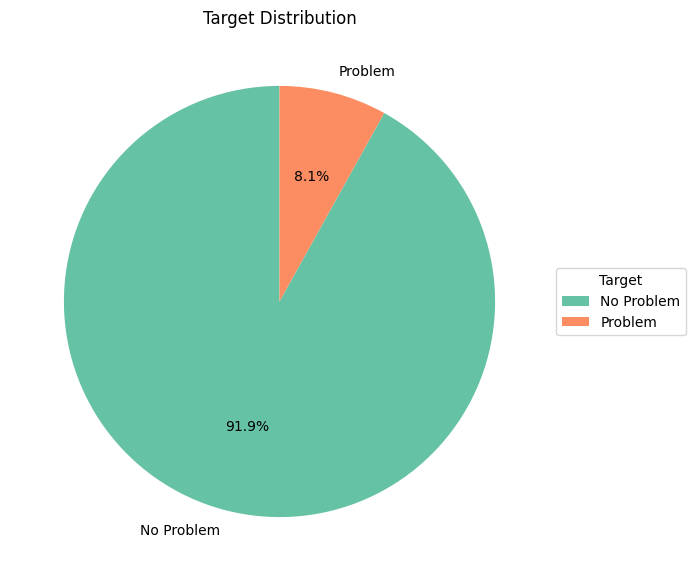

In [62]:
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(
    app_train['TARGET'].value_counts(),
    labels=['No Problem', 'Problem'],
    startangle=90,
    autopct='%1.1f%%',
    colors=['#66c2a5', '#fc8d62'],
    textprops=dict(color="black")
)

ax.legend(
    wedges,
    ['No Problem', 'Problem'],
    title="Target",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

ax.set_title("Target Distribution")

plt.show()

Total aplikasi tercatat dalam data `app_train` adalah 307511. Sebagian besar kredit lancar hanya 8,1% data saja yang bermasalah

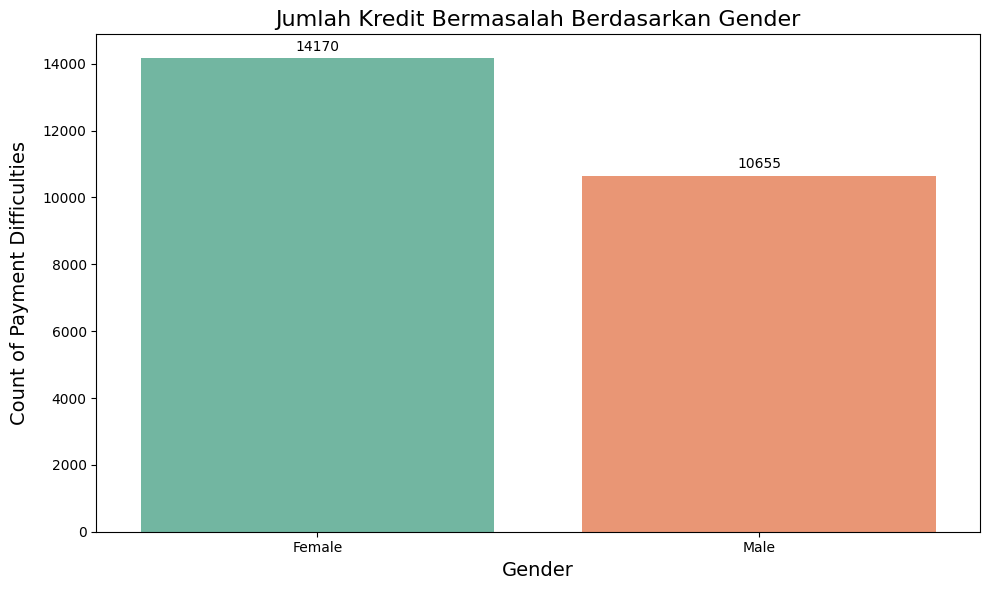

In [63]:
gender_target = app_train.groupby(['CODE_GENDER', 'TARGET']) \
    .agg(TARGET_COUNT=('TARGET', 'size')) \
    .reset_index()

gender_target_filtered = gender_target[gender_target['TARGET'] == 1]

plt.figure(figsize=(10, 6))

bar = sns.barplot(data=gender_target_filtered, x="CODE_GENDER", y="TARGET_COUNT", palette='Set2')
for container in bar.containers:
    bar.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=3)

plt.title('Jumlah Kredit Bermasalah Berdasarkan Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count of Payment Difficulties', fontsize=14, labelpad=10)
plt.xticks([0, 1], ['Female', 'Male'])

plt.tight_layout()
plt.show()


Grafik ini menunjukkan perbandingan jumlah kredit bermasalah antara perempuan dan laki-laki. Dari data tersebut, dapat disimpulkan bahwa:

- Jumlah kredit bermasalah pada perempuan (14.170) lebih tinggi dibandingkan laki-laki (10.655), dengan selisih 3.515 kredit.
- Proporsi kredit bermasalah pada perempuan mencapai 57,08%, sementara pada laki-laki sebesar 42,92%.

Ini menunjukkan bahwa perempuan memiliki proporsi yang lebih besar dalam jumlah total kredit bermasalah dalam data ini.



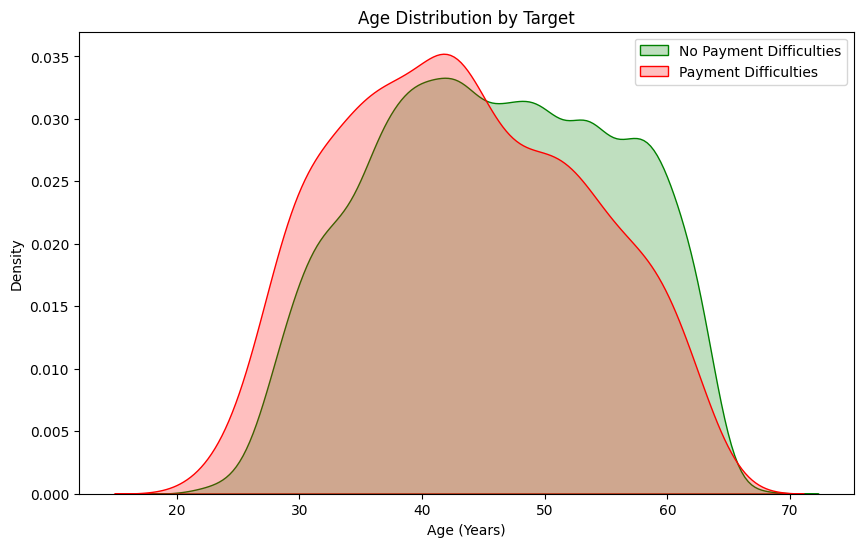

In [64]:
plt.figure(figsize=(10, 6))
sns.kdeplot(app_train_cleaned.loc[app_train_cleaned['TARGET'] == 0, 'YEARS_BIRTH'], 
            label='No Payment Difficulties', fill=True, color='green')
sns.kdeplot(app_train_cleaned.loc[app_train_cleaned['TARGET'] == 1, 'YEARS_BIRTH'], 
            label='Payment Difficulties', fill=True, color='red')
plt.title('Age Distribution by Target')
plt.xlabel('Age (Years)')
plt.ylabel('Density')
plt.legend()
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}'))
plt.show()

Kurva untuk "Payment Difficulties" (merah) sedikit bergeser ke kiri dibandingkan kurva "No Payment Difficulties" (hijau). Ini mengindikasikan bahwa klien yang mengalami kesulitan pembayaran cenderung lebih muda dibandingkan klien yang tidak mengalami kesulitan.

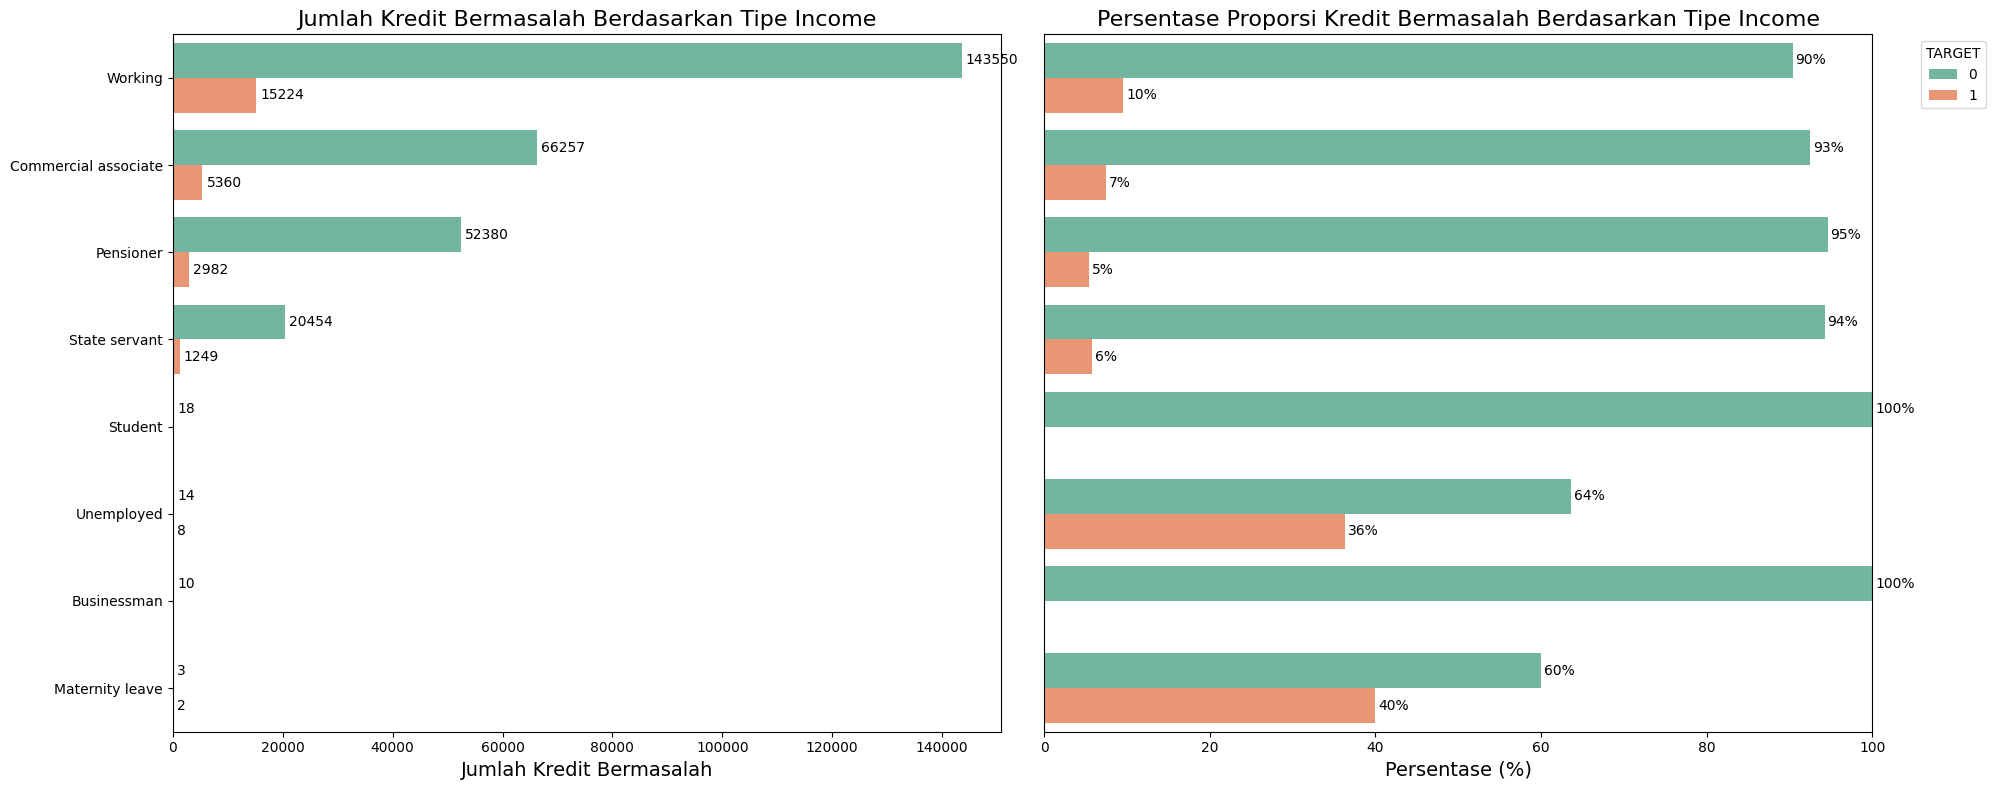

In [153]:
income_type_target = app_train.groupby(['NAME_INCOME_TYPE', 'TARGET']) \
    .agg(TARGET_COUNT=('TARGET', 'size')) \
    .reset_index()
income_type_target['TARGET_PERCENTAGE'] = (income_type_target['TARGET_COUNT'] / income_type_target.groupby('NAME_INCOME_TYPE')['TARGET_COUNT'].transform('sum')) * 100
income_type_target = income_type_target.sort_values(by='TARGET_COUNT', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))  

count = sns.barplot(y='NAME_INCOME_TYPE', x='TARGET_COUNT', hue='TARGET', data=income_type_target, palette='Set2', ax=axes[0])
for container in count.containers:
    count.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=3)
axes[0].set_title('Jumlah Kredit Bermasalah Berdasarkan Tipe Income', fontsize=16)
axes[0].set_xlabel('Jumlah Kredit Bermasalah', fontsize=14)
axes[0].set_ylabel(None)
axes[0].legend_.remove()

bar = sns.barplot(y='NAME_INCOME_TYPE', x='TARGET_PERCENTAGE', hue='TARGET', data=income_type_target, palette='Set2', ax=axes[1])
axes[1].set_title('Persentase Proporsi Kredit Bermasalah Berdasarkan Tipe Income', fontsize=16)
axes[1].set_xlabel('Persentase (%)', fontsize=14)
axes[1].set_ylabel(None)
axes[1].yaxis.set_major_locator(mticker.NullLocator())
axes[1].set_xlim(0, 100)
for container in bar.containers:
    bar.bar_label(container, fmt='%.0f%%', label_type='edge', fontsize=10, padding=2)

axes[1].legend_.remove()
plt.legend(title='TARGET', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

plt.tight_layout()
plt.show()


Grafik ini menunjukkan proporsi kredit bermasalah berdasarkan tipe income. Dari analisis tersebut, dapat disimpulkan bahwa:

- Sebagian besar data terdapat pada tipe income "Working", "Commercial associate", "Pensioner", dan "State servant", yang memiliki total aplikasi dalam jumlah besar. Sedangkan tipe income "Student", "Unemployed", "Businessman", dan "Maternity leave" memiliki jumlah data yang relatif sedikit.

- Meskipun jumlah kredit bermasalah tampak tinggi pada tipe income "Working", "Commercial associate", "Pensioner", dan "State servant", proporsi kredit bermasalahnya relatif kecil (sekitar 6% hingga 10%). Ini menunjukkan bahwa meskipun jumlah kasus kredit bermasalah besar, hal ini disebabkan oleh jumlah total aplikasi yang juga besar. Sebagian besar kredit pada tipe ini tetap lancar.

- Tipe income "Unemployed" dan "Maternity leave" menunjukkan proporsi kredit bermasalah yang tinggi (sekitar 40%). Hal ini perlu menjadi perhatian khusus, karena meskipun jumlah data untuk tipe ini terbatas, proporsi yang tinggi dapat mengindikasikan potensi risiko yang perlu diwaspadai.

- Tipe income "Student" menunjukkan hasil yang positif, dengan 18 data dan tidak ada kasus kredit bermasalah, yang mencerminkan stabilitas pembayaran pada kelompok ini.

Saran tindakan:

- Fokus pada "Unemployed" dan "Maternity leave" sebagai segmen yang memerlukan analisis lebih lanjut. Tingginya proporsi kredit bermasalah dalam kelompok ini meskipun data terbatas bisa menjadi indikator risiko.

- Pertimbangkan untuk meningkatkan analisis risiko berdasarkan tipe income yang memiliki banyak data dan proporsi kredit bermasalah yang kecil, meskipun total jumlah kredit bermasalahnya besar.

- Untuk "Student", "Businessman", dan "Pensioner", perlu dilakukan pemantauan lebih lanjut untuk memastikan tren positif tetap berlanjut.

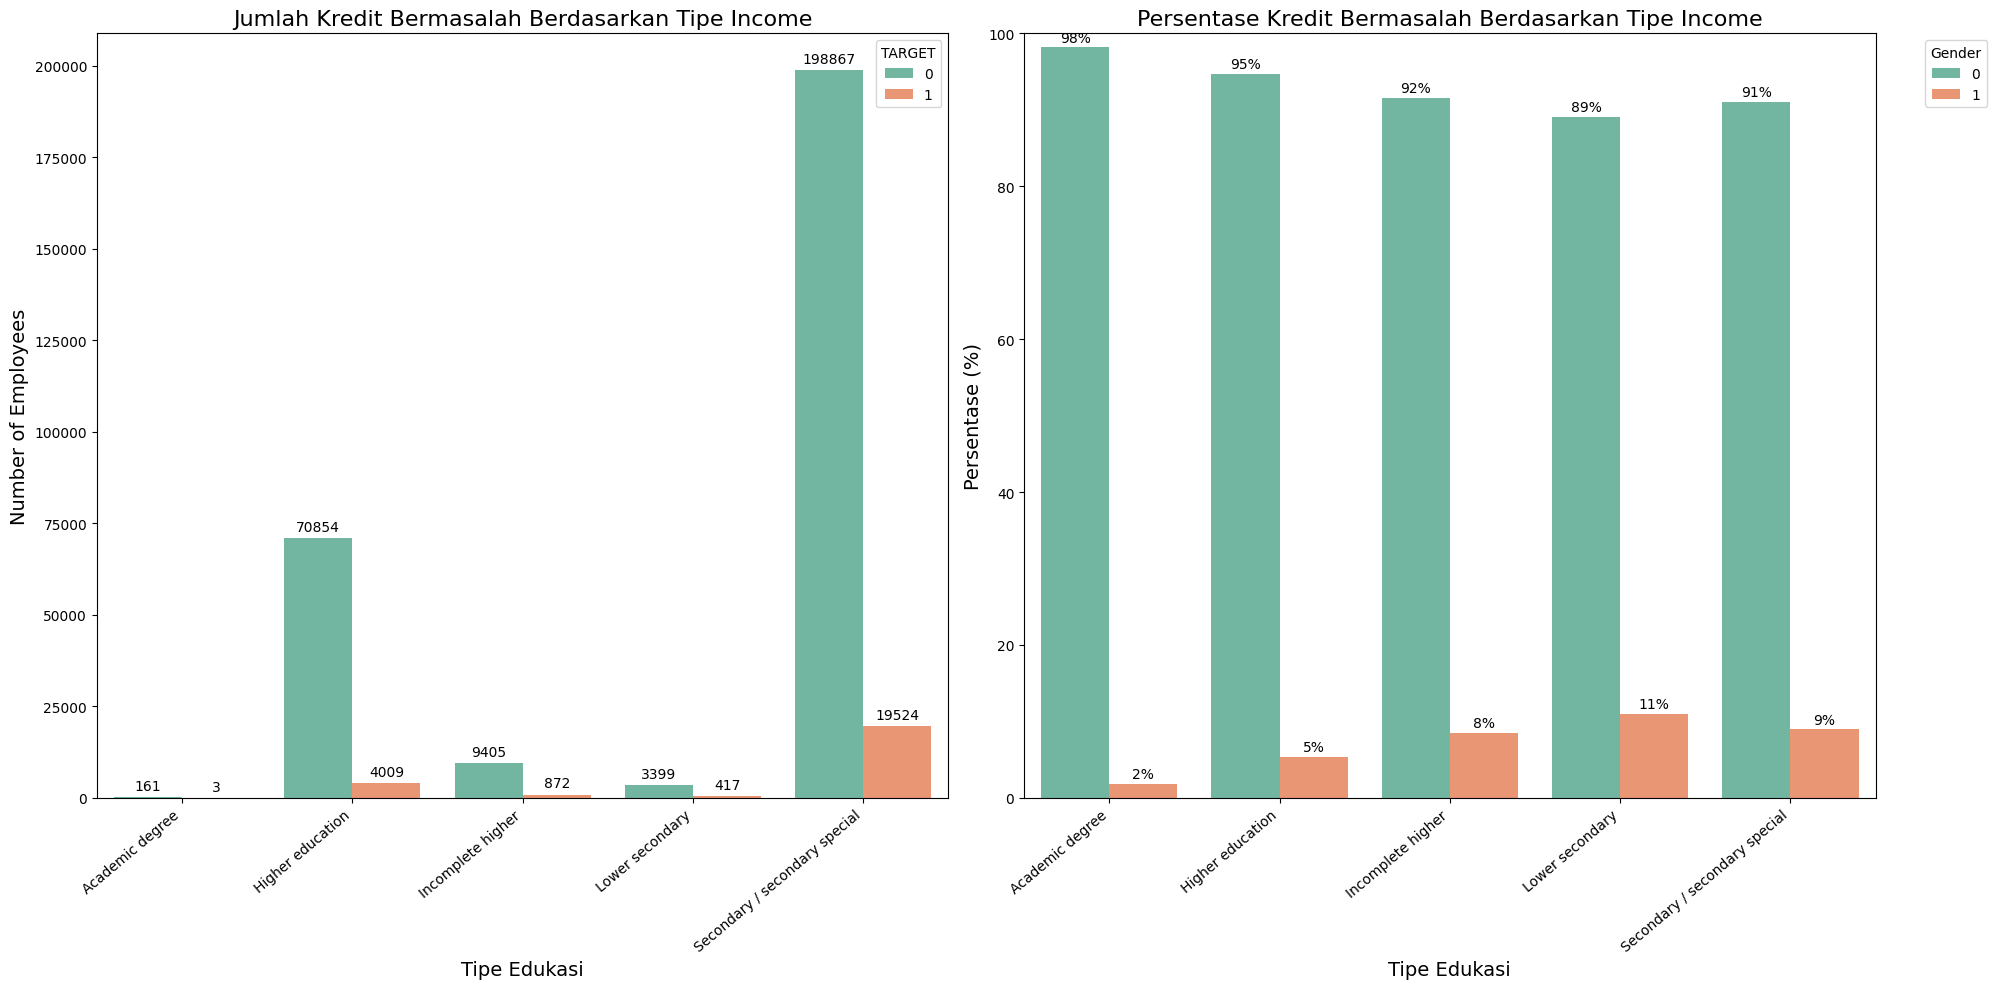

In [175]:
income_type_target = app_train.groupby(['NAME_EDUCATION_TYPE', 'TARGET']) \
    .agg(TARGET_COUNT=('TARGET', 'size')) \
    .reset_index()
income_type_target['TARGET_PERCENTAGE'] = (income_type_target['TARGET_COUNT'] / income_type_target.groupby('NAME_EDUCATION_TYPE')['TARGET_COUNT'].transform('sum')) * 100

fig, axes = plt.subplots(1, 2, figsize=(20, 10))


count = sns.barplot(x='NAME_EDUCATION_TYPE', y='TARGET_COUNT', hue='TARGET', data=income_type_target, palette='Set2', ax=axes[0])
for container in count.containers:
    count.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=3)
axes[0].set_title('Jumlah Kredit Bermasalah Berdasarkan Tipe Income', fontsize=16)
axes[0].set_xlabel('Tipe Edukasi', fontsize=14)
axes[0].set_ylabel('Number of Employees', fontsize=14)

bar = sns.barplot(x='NAME_EDUCATION_TYPE', y='TARGET_PERCENTAGE', hue='TARGET', data=income_type_target, palette='Set2', ax=axes[1])
axes[1].set_title('Persentase Kredit Bermasalah Berdasarkan Tipe Income', fontsize=16)
axes[1].set_xlabel('Tipe Edukasi', fontsize=14)
axes[1].set_ylabel('Persentase (%)', fontsize=14)
axes[1].set_ylim(0, 100)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.0f%%', label_type='edge', fontsize=10, padding=2)
axes[1].legend(title='Gender', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')

plt.tight_layout()

Grafik ini menunjukkan proporsi kredit bermasalah berdasarkan tipe edukasi. Dari analisis tersebut, dapat disimpulkan bahwa:
- Secara jumlah "Secondary / secondary special" memiliki jumlah kredit bermasalah terbanyak. Namun, secara proporsi dari masing masing tipe "Lower secondary" memiliki proporsi jumlah kredit bermasalah terbesar.

- Proporsi terendah berada pada tipe "Academic degree", namun data ini juga memiliki total data terendah

- Dilihat dari persebaran data belum dapat dikatakan pasti secara visual bahwa tipe tertentu mempengaruhi status kredit. 

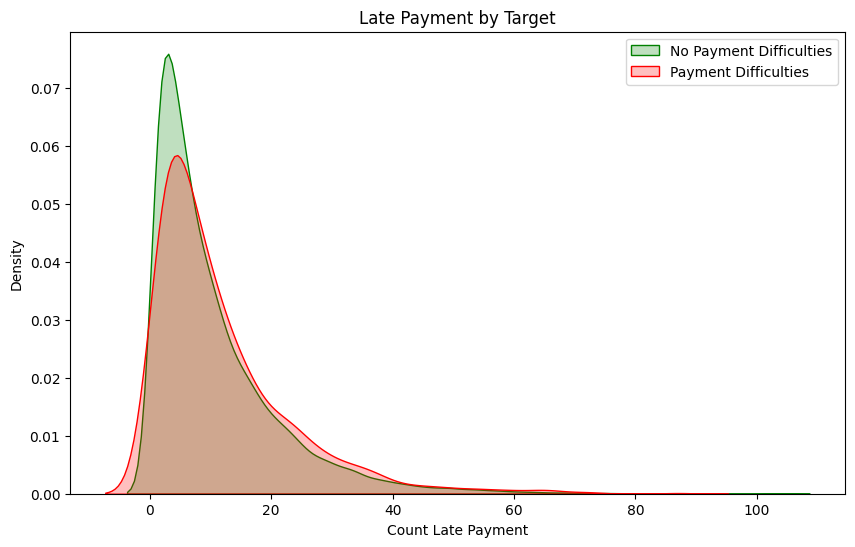

In [177]:
plt.figure(figsize=(10, 6))
sns.kdeplot(app_train_cleaned.loc[app_train_cleaned['TARGET'] == 0, 'LATE_PAYMENTS_COUNT'], 
            label='No Payment Difficulties', fill=True, color='green')
sns.kdeplot(app_train_cleaned.loc[app_train_cleaned['TARGET'] == 1, 'LATE_PAYMENTS_COUNT'], 
            label='Payment Difficulties', fill=True, color='red')
plt.title('Late Payment by Target')
plt.xlabel('Count Late Payment')
plt.ylabel('Density')
plt.legend()
plt.show()

Grafik ini menggambarkan distribuji jumlah pembayaran terlambat berdasarkan status kredit klien. Dari analisis tersebut, dapat disimpulkan bahwa:
- Distribusi jumlah pembayaran terlambat terlihat sangat right-skewed (menceng ke kanan) untuk kedua kelompok, yang berarti sebagian besar data terkonsentrasi di nilai-nilai rendah, dengan beberapa nilai ekstrem yang lebih tinggi.

- Klien yang mengalami kesulitan pembayaran cenderung memiliki jumlah pembayaran terlambat yang lebih tinggi dan variasi yang lebih besar dalam jumlah keterlambatan tersebut dibandingkan dengan klien yang tidak mengalami kesulitan.

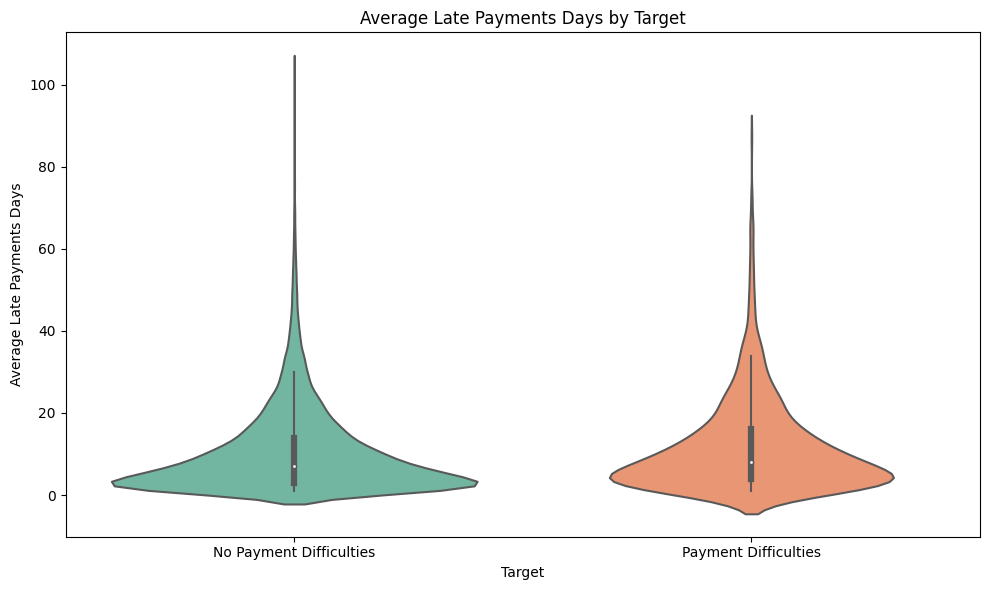

In [130]:
plt.figure(figsize=(10, 6))
sns.violinplot(X_new, x=y, y='LATE_PAYMENTS_COUNT', palette='Set2')
plt.title('Average Late Payments Days by Target')
plt.xlabel('Target')
plt.xticks([0, 1], ['No Payment Difficulties', 'Payment Difficulties'])
plt.ylabel('Average Late Payments Days')

plt.tight_layout()
plt.show()


Grafik ini menggambarkan Perbedaan distribusi rata rata hari pembayaran terlambat berdasarkan status kredit klien. Dari analisis tersebut, dapat disimpulkan bahwa:

-  Orang yang bermasalah dengan pembayaran cenderung punya rata-rata lama keterlambatan yang lebih panjang dan lebih bervariasi dibandingkan orang yang lancar.  

- Kelompok orang yang lancar "Biolanya" lebih sempit dan puncaknya lebih tinggi. Ini artinya sebagian besar orang di kelompok ini punya rata-rata keterlambatan yang sebentar, bahkan mendekati nol hari (artinya bayar tepat waktu). Hanya sedikit orang di kelompok ini yang punya rata-rata keterlambatan yang lama.

- Kelompok orang yang bermasalah: "Biolanya" lebih lebar dan lebih pendek. Ini artinya orang-orang di kelompok ini punya variasi lama keterlambatan yang lebih besar. Ada yang terlambat sebentar, ada juga yang terlambat sangat lama. Rata-rata keterlambatan mereka cenderung lebih lama dibandingkan kelompok orang yang lancar.

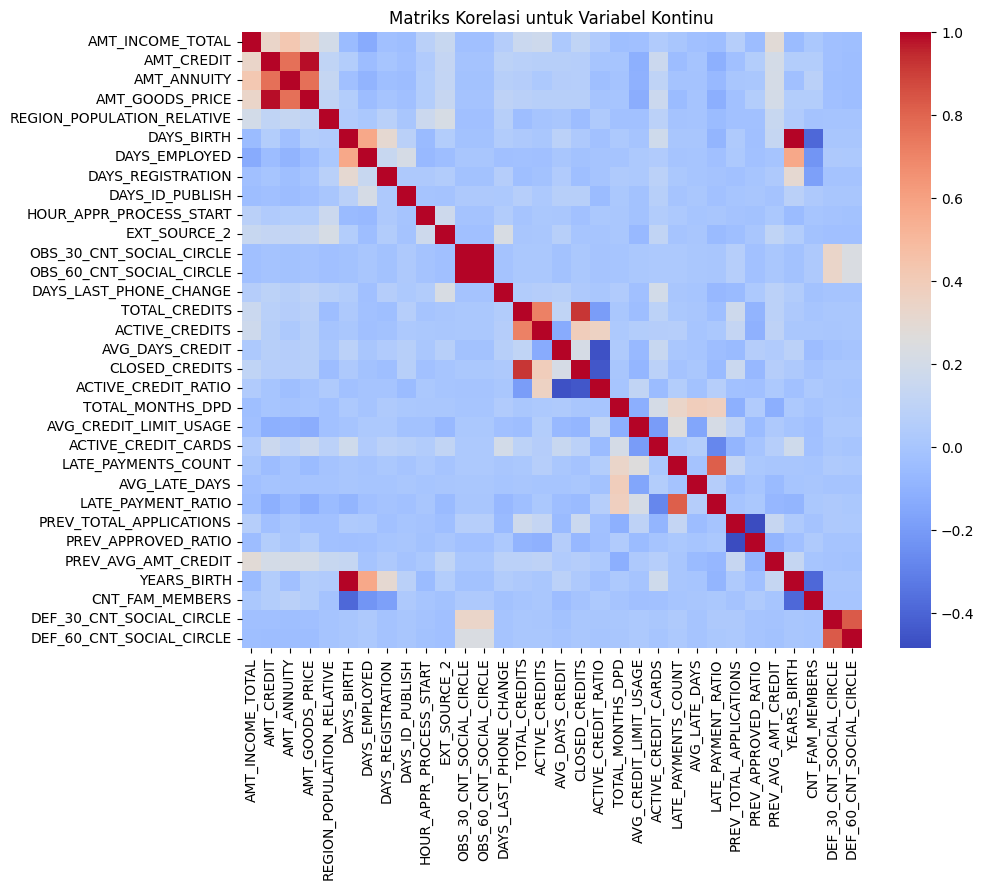

In [123]:
correlation_matrix = X[continuous].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Matriks Korelasi untuk Variabel Kontinu')
plt.show()

Grafik ini menggambarkan hubungan liniear antar variabel kontinu dalam data, tujuan dari grafik ini adalah apakah terdapat hubungan variabel menarik dalam data. Hasil menunjukan terdapat hubungan linear logis dalam data seperti AMT_CREDIT dan AMT_GOODS_PRICE memiliki korelasi positif yang sangat kuat (warna merah pekat). Ini logis, karena biasanya jumlah kredit yang diberikan berbanding lurus dengan harga barang yang dibeli. Semakin mahal barangnya, semakin besar kemungkinan kredit yang dibutuhkan. Tidak ada hubungan variabel yang spesial dalam data.

## Machine Learning Implementation

In [185]:
rf = RandomForestClassifier(random_state=42)
lr = LogisticRegression(random_state=42, max_iter=100000)
svm = SVC(max_iter=-1, kernel='rbf', random_state=42)
knn = KNeighborsClassifier() 
dt = DecisionTreeClassifier(random_state=42)  
nb = GaussianNB() 
gb = GradientBoostingClassifier(random_state=42)  

In [186]:
models = {
    'Random Forest': rf,
    'Logistic Regression': lr,
    'SVM': svm,
    'K-Nearest Neighbors': knn,
    'Decision Tree': dt,
    'Naive Bayes': nb,
    'Gradient Boosting': gb
}

In [187]:
def evaluate_models(X, y, models, scoring=None, cv=5):
    """
    Fungsi untuk mengevaluasi berbagai model dengan cross-validation.

    Parameters:
    X: array-like or DataFrame
        Fitur input (train data).
    y: array-like or Series
        Target output (train labels).
    models: dict, model-model yang akan dievaluasi.
    scoring: list of str, optional
        List skor metrik yang akan dihitung, seperti ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'].
    cv: int, default=5
        Jumlah fold untuk cross-validation.

    Returns:
    DataFrame: Tabel hasil cross-validation untuk setiap model.
    """

    if scoring is None:
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    results = []

    for model_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)

        avg_accuracy = cv_results['test_accuracy'].mean()
        avg_precision = cv_results['test_precision'].mean()
        avg_recall = cv_results['test_recall'].mean()
        avg_f1 = cv_results['test_f1'].mean()
        avg_auc = cv_results['test_roc_auc'].mean()

        results.append({
            'Model': model_name,
            'Avg_Accuracy': avg_accuracy,
            'Avg_Precision': avg_precision,
            'Avg_Recall': avg_recall,
            'Avg_F1 Score': avg_f1,
            'Avg_AUC': avg_auc
        })

    results_df = pd.DataFrame(results)

    return results_df

In [188]:
def highlight_max(dataframe):
    return dataframe.highlight_max(
        subset=['Avg_Accuracy', 'Avg_Precision', 'Avg_Recall', 'Avg_F1 Score', 'Avg_AUC'],
        color='lightgreen',
        axis=0
    )

In [189]:
smt_result = evaluate_models(X_smt, y_smt, models=models)
higlight_smt_result = highlight_max(smt_result.style)
higlight_smt_result

,Model,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1 Score,Avg_AUC
0,Random Forest,0.963121,0.984204,0.941482,0.958866,0.993906
1,Logistic Regression,0.661167,0.666174,0.646362,0.656065,0.729763
2,SVM,0.912772,0.881402,0.954153,0.916006,0.972117
3,K-Nearest Neighbors,0.786479,0.700914,0.999554,0.823998,0.934718
4,Decision Tree,0.891189,0.884936,0.901525,0.888592,0.891181
5,Naive Bayes,0.635658,0.609331,0.755884,0.674637,0.712835
6,Gradient Boosting,0.936409,0.973270,0.898219,0.924401,0.966520


In [190]:
cc_result = evaluate_models(X_cc, y_cc, models=models)
hightlight_cc_result = highlight_max(cc_result.style)
hightlight_cc_result

,Model,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1 Score,Avg_AUC
0,Random Forest,0.959342,0.946141,0.974604,0.960043,0.995342
1,Logistic Regression,0.929354,0.950025,0.906521,0.927697,0.967362
2,SVM,0.957302,0.947356,0.968497,0.957804,0.990867
3,K-Nearest Neighbors,0.803854,0.979151,0.620921,0.759744,0.907204
4,Decision Tree,0.916663,0.917857,0.915658,0.916543,0.916653
5,Naive Bayes,0.910558,0.938934,0.878069,0.907388,0.973249
6,Gradient Boosting,0.974077,0.972171,0.976629,0.974287,0.995923


In [195]:
best_model = models['Gradient Boosting']
best_model.fit(X_cc, y_cc)

joblib.dump(best_model, 'output/model.pkl')

['model.pkl']

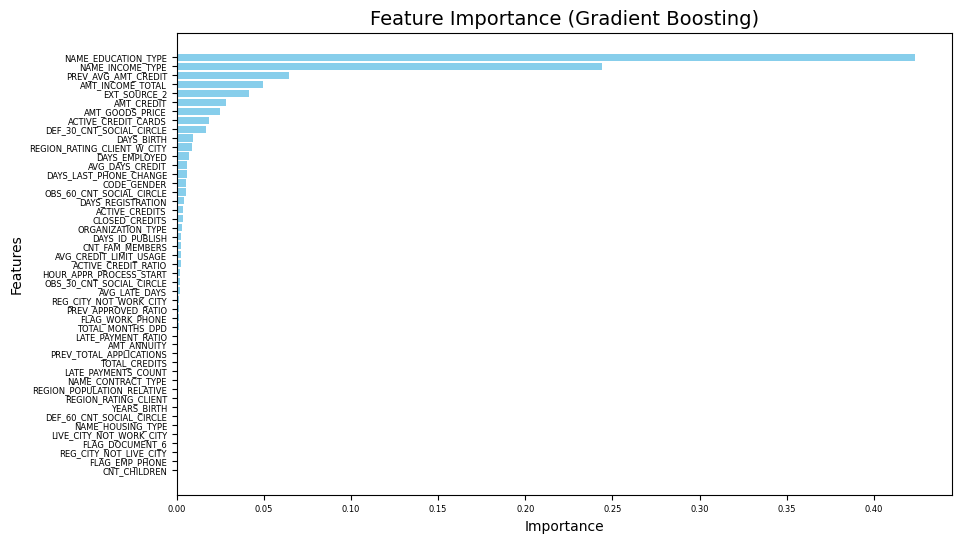

In [191]:


gb.fit(X_cc, y_cc)

feature_importances = gb.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_new.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize=10) 
plt.ylabel('Features', fontsize=10)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)  
plt.title('Feature Importance (Gradient Boosting)', fontsize=14) 
plt.gca().invert_yaxis()
plt.show()


In [192]:
feature_importance_df

,Feature,Importance
3,NAME_EDUCATION_TYPE,0.423420
2,NAME_INCOME_TYPE,0.244204
41,PREV_AVG_AMT_CREDIT,0.064545
14,AMT_INCOME_TOTAL,0.049558
24,EXT_SOURCE_2,0.041566
15,AMT_CREDIT,0.028196
17,AMT_GOODS_PRICE,0.024912
35,ACTIVE_CREDIT_CARDS,0.018695
44,DEF_30_CNT_SOCIAL_CIRCLE,0.016613
19,DAYS_BIRTH,0.009279


**Hasil Peforma Klasifikasi**

Data dilatih menggunakan 7 metode klasifikasi dengan menggunakan SMOTE dan Cluster Centroid untuk menyeimbangkan target. Kemampuan model diuji melalui metrik Akurasi, Presisi, Recall. F1-Score dan AUC. Untuk memastikan tidak terjadi overfitting, setiap model diuji menggunakan Cross Validation sebanyak 5 Fold

Hasil terbaik dari SMOTE adalah Random Forest dan Cluster Centroid adalah Gradient Boosting

|Model|Avg_Accuracy|Avg_Precision|Avg_Recall|Avg_F1 Score|Avg_AUC|
|-----|------------|-------------|----------|------------|-------|
|Random Forest|0.963121|0.984204|0.941482|0.958866|0.993906|
|Gradient Boosting|0.974077|0.972171|0.976629|0.974287|0.995923|

Pentingnya Metrik Evaluasi dalam Memprediksi Kredit Bermasalah:
1. Akurasi mencerminkan persentase prediksi yang benar dari total data
2. Presisi menunjukkan proporsi prediksi positif nasabah yang diprediksi bermasalah memang benar-benar bermasalah
3. Recall mengukur seberapa baik model mendeteksi semua kasus positif (kredit bermasalah). Recall tinggi penting untuk meminimalkan risiko gagal mendeteksi nasabah bermasalah, yang dapat berdampak pada kerugian finansial bagi perusahaan.
4. F1-Score dalah rata-rata harmonis dari presisi dan recall. Metrik ini sangat relevan ketika ada kebutuhan untuk menjaga keseimbangan antara presisi dan recall, seperti pada prediksi kredit bermasalah, di mana kedua aspek ini sama-sama krusial.
5. AUC (Area Under the Curve) menggambarkan kemampuan model dalam membedakan antara kelas positif dan negatif. Nilai AUC yang tinggi (mendekati 1) menunjukkan bahwa model sangat baik dalam membedakan kredit bermasalah dari kredit tidak bermasalah, bahkan pada berbagai threshold.

Berdasarkan hasil percobaan klasifikasi yang dilakukan, model  **Gradient Boosting dengan Cluster Centroid**  terbukti memberikan kinerja terbaik dalam memprediksi kredit bermasalah. Model Random Forest memberikan nilai Presisi yang lebih baik namun memberikan nilai recall yang rendah, sedangkan Gradient Boosting dapat memberikan nilai presisi dan recall yang tinggi dan seimbang sehingga model tersebut memberikan performa yang sangat baik. 

**Featue Importance**

Fitur penting yang berkontribusi dalam keputusan klasifikasi adalah `NAME_EDUCATION_TYPE` dan `NAME_INCOME_TYPE`. Fitur fitur lain hanya memberikan nilai kontribusi yang kecil dalam klasifikasi.

**Kesimpulan**

Penerapan model ini dapat membantu Home Kredit untuk **mengidentifikasi nasabah berisiko gagal bayar** dengan lebih akurat dan tepat waktu. Dengan menggunakan **Cluster Centroid** untuk menangani ketidakseimbangan data, model ini dapat meningkatkan prediksi kredit bermasalah meskipun terdapat lebih banyak nasabah yang tidak berisiko dibandingkan yang berisiko.

## Reggresion Analysis

Analisis regresi dilakukan untuk meneliti lebih lanjut bagaimana tipe edukasi dan tipe pemasukan mempengaruhi kredit bermasalah. Analisis dilakukan menggunakan bantuan `statsmodels` untuk mendapatkan coefisient regresi logistik

In [156]:
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X_train, y_train)

In [157]:
dataset = pd.concat([X_cc, y_cc], join='outer', axis=1)
dataset.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,...,LATE_PAYMENT_RATIO,PREV_TOTAL_APPLICATIONS,PREV_APPROVED_RATIO,PREV_AVG_AMT_CREDIT,YEARS_BIRTH,CNT_FAM_MEMBERS,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,CNT_CHILDREN,TARGET
0,0,0,5,3,1,1,0,2,2,0,...,0.079606,4,0.717785,43674.191529,41,2.303030,0.181818,1.212121e-01,0,0
1,0,0,5,3,1,1,0,2,2,0,...,0.090431,6,0.786190,125471.422650,46,2.080000,0.040000,1.387779e-17,0,0
2,0,0,5,3,1,1,0,1,1,0,...,0.126789,7,0.679875,283211.897388,41,2.058824,0.176471,1.176471e-01,0,0
3,0,0,5,3,1,1,0,1,1,0,...,0.052518,9,0.635000,526965.566250,47,2.400000,0.200000,-1.387779e-17,0,0
4,0,0,3,3,1,0,0,1,1,0,...,0.053545,4,0.833333,142131.581250,61,1.875000,0.000000,0.000000e+00,0,0


In [ ]:
formula = 'TARGET ~ C(NAME_EDUCATION_TYPE) + C(NAME_INCOME_TYPE)'

model = smf.logit(formula=formula, data=dataset).fit(maxiter=1000)
res = model.summary()
print(res)

Optimization terminated successfully.
         Current function value: 0.235975
         Iterations 215
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:                 1968
Model:                          Logit   Df Residuals:                     1958
Method:                           MLE   Df Model:                            9
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                  0.6596
Time:                        12:55:53   Log-Likelihood:                -464.40
converged:                       True   LL-Null:                       -1364.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.9494      0.205      4.639      0.000 

Hasil diatas menunjukan output regresi logistik menggunakan `statmodels` dimana kita dapat melihat coefisien dan kontribusi variabel terhadap target. Berdasarkan hasil tersebut didapatkan bahwa terdapat beberapa tipe income yang belum signifikan mempengaruhi target. Pseudo R-square menunjukkan nilai yang tinggi, yang berarti model memiliki kemampuan yang baik dalam menjelaskan variabilitas target berdasarkan variabel independen yang digunakan. Namun, adanya beberapa variabel yang belum signifikan mengindikasikan kemungkinan adanya multikolinearitas atau variabel yang kurang relevan dalam memprediksi kredit bermasalah.

Selanjutnya, akan dilakukan analisis regresi logistik dengan regularisasi, atau yang dikenal sebagai Lasso Regression, untuk mengidentifikasi apakah variabel tersebut benar-benar tidak signifikan atau dapat dipertahankan dalam model setelah penalti diterapkan.

In [178]:
X = dataset[['NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE']].astype('object')
X = pd.get_dummies(X, drop_first=True)  
y = dataset['TARGET']

X = sm.add_constant(X)

# LASSO (L1 penalized regression)
model = sm.Logit(y, X)
lasso_result = model.fit_regularized(method='l1', alpha=0.1)

print(lasso_result.summary())


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.23780020151862208
            Iterations: 163
            Function evaluations: 163
            Gradient evaluations: 163
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:                 1968
Model:                          Logit   Df Residuals:                     1958
Method:                           MLE   Df Model:                            9
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                  0.6593
Time:                        13:22:34   Log-Likelihood:                -464.71
converged:                       True   LL-Null:                       -1364.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

C:\Users\HP\AppData\Local\Temp\ipykernel_15384\2221101215.py:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X = pd.get_dummies(X, drop_first=True)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 10 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


hasil diatas menunjukan regresi logistik setelah melalui reguralisasi. Hasil menunjukan bahwa seluruh tipe income memberikan kontribusi yang signifikan dengan p - value < 0.05. Namun perlu dilihat terlebih dahulu interpretasi odds ratio model tersebut

In [172]:
odds_ratio = np.exp(lasso_result.params)

conf = lasso_result.conf_int()
conf_odds_ratio = np.exp(conf)
conf_odds_ratio.columns = ['2.5%', '97.5%']

odds_ratio_df = pd.concat([odds_ratio, conf_odds_ratio], axis=1)
odds_ratio_df.columns = ['Odds Ratio', '2.5%', '97.5%']

with pd.option_context('display.float_format', '{:.2f}'.format):
    print(odds_ratio_df)


                       Odds Ratio  2.5%  97.5%
const                        2.55  1.71   3.80
NAME_EDUCATION_TYPE_2        0.12  0.07   0.22
NAME_EDUCATION_TYPE_3        0.05  0.02   0.10
NAME_EDUCATION_TYPE_4        3.51  2.31   5.34
NAME_INCOME_TYPE_2           0.00  0.00   0.68
NAME_INCOME_TYPE_3           0.16  0.10   0.25
NAME_INCOME_TYPE_4           0.22  0.13   0.35
NAME_INCOME_TYPE_5           0.00  0.00   0.34
NAME_INCOME_TYPE_6           0.00  0.00   0.85
NAME_INCOME_TYPE_7           5.94  3.47  10.15


Berdasarkan output odds ratio model regresi reguralisasi, dapat disimpulkan bahwa:

**1. Pengaruh Education Type terhadap Kredit Bermasalah**

|Education Type|Odds Ratio|Interpretasi|
|--------------|----------|------------|
|Incomplete Higher (2)|0.12|Orang dengan Incomplete Higher memiliki 88% lebih rendah risiko kredit bermasalah dibandingkan dengan yang memiliki Higher Education.|
|Lower Secondary (3)|0.05|Orang dengan Lower Secondary memiliki 95% lebih rendah risiko kredit bermasalah dibandingkan dengan Higher Education.|
|Secondary / Special (4)|3.51|Orang dengan Secondary / Special Education memiliki 3.5 kali lebih tinggi risiko mengalami kredit bermasalah dibandingkan dengan Higher Education.|

Kesimpulan:
- Orang dengan pendidikan lebih rendah (Lower Secondary & Incomplete Higher) justru lebih jarang mengalami kredit bermasalah dibandingkan dengan mereka yang punya Higher Education.
- Orang dengan Secondary / Special Education memiliki risiko lebih tinggi mengalami kredit bermasalah dibandingkan Higher Education.  Mungkin orang dengan Higher Education lebih cermat dalam mengelola keuangan atau mendapatkan pekerjaan yang lebih stabil dibandingkan Secondary/Special Education.

**2. Pengaruh Income Type terhadap Kredit Bermasalah**

|Income Type|Odds Ratio|Interpretasi|
|--------------|----------|------------|
|Maternity Leave (2)|0.00|Hampir tidak ada hubungan signifikan, tetapi batas atas (0.68) menunjukkan sedikit pengaruh.|
|Pensioner (3)|0.16|Pensioners memiliki 84% lebih rendah risiko kredit bermasalah dibandingkan Commercial Associates.|
|State Servant (4)|0.22|State Servants memiliki 78% lebih rendah risiko kredit bermasalah dibandingkan Commercial Associates.|
|Student (5)|0.00|Hampir tidak ada hubungan signifikan, tetapi batas atas (0.34) menunjukkan mungkin ada sedikit pengaruh.|
|Unemployed (6)|0.00|Hampir tidak ada hubungan signifikan, tetapi batas atas (0.85) menunjukkan ada kemungkinan kecil pengaruh.|
|Working (7)|5.94|Orang yang bekerja (Working) memiliki hampir 6 kali lebih tinggi risiko mengalami kredit bermasalah dibandingkan Commercial Associates.|

Kesimpulan:

- Pensioners dan State Servants memiliki risiko kredit bermasalah yang jauh lebih rendah dibandingkan Commercial Associates, kemungkinan karena mereka memiliki pendapatan tetap (pensiun/gaji dari pemerintah).
- Orang yang bekerja (Working) justru memiliki hampir 6 kali lebih besar kemungkinan mengalami kredit bermasalah!
- Maternity Leave, Students, dan Unemployed tidak memiliki pengaruh signifikan terhadap risiko kredit bermasalah.
- Kemungkinan besar, orang yang bekerja (Working) memiliki risiko lebih tinggi karena mereka memiliki pendapatan tidak tetap, pengeluaran tinggi, atau mengambil kredit dengan jumlah besar dibandingkan kategori lainnya.

**3.  Kesimpulan Utama**
- Siapa yang lebih berisiko mengalami kredit bermasalah?

  - Orang dengan Secondary / Special Education lebih rentan mengalami kredit bermasalah dibandingkan yang memiliki Higher Education.
  - Orang yang bekerja (Working) memiliki risiko tertinggi untuk mengalami kredit bermasalah.

- Siapa yang lebih aman dalam kredit?

  - Pensioners dan State Servants memiliki risiko kredit bermasalah yang jauh lebih rendah karena mereka memiliki pendapatan yang stabil.
  - Orang dengan Lower Secondary & Incomplete Higher Education juga memiliki risiko lebih rendah dibandingkan Higher Education.

**4. Implikasi untuk Kebijakan Kredit**

Jika Home Credit ingin mengurangi kredit bermasalah:
- Lebih berhati-hati dalam memberikan kredit ke orang yang bekerja karena mereka lebih rentan gagal bayar.
- Memperhatikan orang dengan Secondary Education lebih dalam sebelum memberikan kredit.
- Pensioners dan State Servants lebih aman untuk diberikan kredit karena risiko mereka lebih rendah.


## Business Recommendation

Kategori pendidikan dan tingkat pendapatan klien terbukti berpengaruh signifikan terhadap klasifikasi kredit bermasalah. Analisis menunjukkan bahwa klien dengan status pekerjaan working dan tingkat pendidikan secondary/special memiliki risiko lebih tinggi terhadap kredit bermasalah. Temuan ini diperoleh melalui rangkaian proses persiapan data, termasuk feature engineering dan data cleaning, seleksi fitur menggunakan uji chi-square, penyeimbangan kelas dengan metode Cluster Centroid, serta penerapan algoritma gradient boosting untuk klasifikasi. Selain itu, pengaruh variabel dianalisis lebih lanjut menggunakan regresi logistik untuk mendukung interpretasi hasil.


Berikut adalah action items yang dapat diambil oleh perusahaan berdasarkan analisis risiko kredit:
1. Penyusunan Kebijakan Risiko Kredit Berdasarkan Education Type
   - Segmentasi Klien Berdasarkan Pendidikan:
     - Tingkatkan pengawasan pada klien dengan pendidikan Secondary / Special.
     - Buat kebijakan kredit yang lebih fleksibel untuk klien dengan pendidikan Lower Secondary dan Incomplete Higher, karena mereka cenderung memiliki risiko kredit bermasalah lebih rendah.
   - Penggunaan Pendidikan sebagai Faktor Penilaian Kredit:
     - Gunakan tingkat pendidikan sebagai salah satu parameter dalam skoring kredit.
     - Pertimbangkan pemberian plafon kredit lebih rendah atau tenor lebih pendek untuk klien dengan Secondary / Special Education.
2. Optimalisasi Kebijakan Kredit Berdasarkan Income Type
   - Identifikasi Klien Berisiko Tinggi:
     - Klien dengan status pekerjaan Working memerlukan perhatian khusus karena mereka memiliki risiko hampir 6 kali lebih tinggi untuk kredit bermasalah.
     - Batasi jumlah kredit yang dapat diajukan oleh klien dalam kategori ini atau tambahkan persyaratan lebih ketat, seperti agunan atau analisis keuangan mendalam.
   - Penargetan Klien Berisiko Rendah:
     - Tingkatkan promosi dan penawaran kredit kepada Pensioners dan State Servants, karena mereka memiliki pendapatan stabil dan risiko lebih rendah.
   - Tinjau Kategori Non-Signifikan:
     - Kategori seperti Maternity Leave, Students, dan Unemployed tidak menunjukkan pengaruh signifikan terhadap kredit bermasalah, namun tetap penting untuk menganalisis kasus individual sebelum memberikan kredit.
3. Penguatan Analisis Kredit
   - Penambahan Analisis Pendapatan:
     - Lakukan analisis pendapatan lebih mendalam pada klien dengan status Working untuk memahami pengeluaran dan pola pengelolaan keuangan mereka.
   - Evaluasi Kapasitas Pembayaran:
     - Untuk kategori pendidikan dan pekerjaan dengan risiko tinggi, tambahkan persyaratan untuk memberikan bukti kapasitas pembayaran, seperti riwayat pendapatan atau laporan keuangan.
4. Pengembangan Strategi untuk Mengurangi Kredit Bermasalah
   - Edukasi Keuangan:
     - Sediakan program edukasi keuangan bagi klien dengan pendidikan Secondary / Special, untuk meningkatkan kesadaran tentang pengelolaan utang dan pengeluaran.
   - Peningkatan Monitoring & Early Warning System:
     - Implementasikan sistem pemantauan dini untuk mendeteksi tanda-tanda potensi gagal bayar, terutama pada klien yang termasuk dalam kategori risiko tinggi.
   - Penguatan Komunikasi dan Pendekatan Proaktif:
     - Bangun komunikasi yang lebih proaktif dengan klien dalam kategori risiko tinggi untuk memberikan solusi restrukturisasi kredit atau saran keuangan jika diperlukan.

Dengan menerapkan action items ini, perusahaan dapat meningkatkan efektivitas kebijakan kredit, mengurangi risiko gagal bayar, dan memperbaiki portofolio kredit secara keseluruhan.